In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [3]:
def winsorize(s, lower, upper):
    """Winsorizes a pandas series.
    
    Args:
        s (pandas.Series): the series to be winsorized
        lower, upper (int): number between 0 to 100
    """
    return s.clip(np.nanpercentile(s.values, lower),
                  np.nanpercentile(s.values, upper))

In [4]:
def demean(df, column, by):
    """Demean a column in a pandas DataFrame.
    
    Args:
        df (pandas.DataFrame): data
        column (str): the column to be demeaned
        by (list of str): the column names
    """
    return (
        df[column].values -
        df.loc[:, by + [column]].groupby(by).transform(np.nanmean).values.squeeze())

In [14]:
def plot(df, y, x,
         treat='treat',
         cmap={0: 'b', 1: 'r'},
         frac=0.66, it=3):
    # regression
    results = smf.ols(y + ' ~ ' + treat, data=df.dropna(subset=[x, y])).fit()
    y_coef = results.params[treat]
    results = smf.ols(x + ' ~ ' + treat, data=df.dropna(subset=[x, y])).fit()
    x_coef = results.params[treat]
    results = smf.ols(x + ' ~ ' + y, data=df.dropna(subset=[x, y])).fit()
    scale = results.params[y]
    # make figure
    fig, ax = plt.subplots()
    lowess = sm.nonparametric.lowess(
        df[y].values, df[x].values, frac=frac, it=it)
    ax.plot(lowess[:, 0], lowess[:, 1], color='dimgray', linewidth=2)
    for cmap_value, cmap_color in cmap.items():
        y_col = df.loc[df[treat] == cmap_value, y]
        x_col = df.loc[df[treat] == cmap_value, x]
        lowess = sm.nonparametric.lowess(y_col, x_col, frac=frac, it=it)
        ax.plot(lowess[:, 0], lowess[:, 1],
                marker='x', color=cmap_color, alpha=0.5)
    ax.set_title(
        f'Observed effects on x: {x_coef:.4f}\n' +
        f'Estimated effects: {y_coef:.4f} * {scale:.4f} = {(y_coef * scale):.4f}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    return fig, ax

In [6]:
np.random.seed(0)

In [7]:
pd.set_option('display.max_rows', 300)

In [8]:
CENSUS_GPS_IN_DIR = 'data/GiveDirectly/Survey/GE_HH_Census_2017-07-17_cleanGPS.csv'
CENSUS_MASTER_IN_DIR = 'data/GiveDirectly/Survey/GE_HH-Census_Analysis_RA_2017-07-17.dta'
SURVEY_HHSIZE_IN_DIR = 'data/GiveDirectly/Survey/GE_HH-Survey_S1_S4_2016-08-16.dta'
SURVEY_IN_DIR = 'data/GiveDirectly/Survey/GE_Luna_Extract_2018-09-19.dta'
SAT_IN_GEOM_DIR = 'data/Experiment4/sat.geojson'

OUT_DIR = 'data/Experiment4/output/'

## GE Survey

Potential reasons for low correlation coefficients:

- Homogenous unrepresentative sample on eligible households (highly likely)
- Misspecified outcome variable (highly likely)
- Substitution between roof materials and consumption in treated sample (somewhat likely)
- crappy ML prediction of building polygon, missing thatched roof buildings (somewhat likely)
- Imperfect geocoding, matched to neighbors or non-residential structures (somewhat likely)
- Time mismatch between satellite and survey (unlikely)

In [9]:
df_svy = pd.read_stata(SURVEY_IN_DIR)
df_svy = df_svy.dropna(
    subset=['s19_gps_latitude', 's19_gps_longitude',
            'p1_assets_wins', 'p2_consumption_wins']).reset_index(drop=True)
df_svy.loc[:, 'village_code'] = df_svy['s1_hhid_key'].str.split('-', expand=True).loc[:, 0]
df_svy.loc[:, 's1_hhid_key'] = df_svy['s1_hhid_key'].str.replace('-', '')

df_svy = df_svy.loc[:, [
    's19_gps_latitude', 's19_gps_longitude',
    's1_hhid_key', 's6_q1_haselectricity', 'p1_6_nonthatchedroof',
    'p2_consumption_wins', 'treat', 'p1_assets_wins', 'village_code',
    'satcluster',
]]

Note to self: this part needs more work. Several issues:

1. Is this version of survey the final one? Hard to tell from what I can see in Dropbox. Maybe I should ask Michael to send another version.
2. There are duplicates in survey_id. I checked and the duplicates all have this structure: two observations with the same survey_id, one with the correct respondent id and one with a different respondent id. It doesn't look like one is incomplete while the other is, or one is the target respondent while the other is not. I don't really understand what that means. The hhsize variable can be different (and often is) across different observations. I'm dropping all but the last observation at the moment.
3. When merging, about 800 households are not matched to hhsize. This includes households with N or U prefixes.

In [10]:
# merge in household size
df_hhsize = pd.read_stata(SURVEY_HHSIZE_IN_DIR)
df_hhsize = df_hhsize.drop_duplicates(subset=['survey_id'], keep='last')
df_hhsize = df_hhsize.loc[:, ['survey_id', 's4_q1_hhmembers']].copy()
df_hhsize.loc[:, 's4_q1_hhmembers'] = df_hhsize['s4_q1_hhmembers'] + 1
df_svy = pd.merge(
    df_svy, df_hhsize,
    how='left', left_on='s1_hhid_key', right_on='survey_id')

In [11]:
# calculate per capita consumption / assets
df_svy.loc[:, 'p2_consumption_pc_wins'] = df_svy['p2_consumption_wins'].values / df_svy['s4_q1_hhmembers'].values
df_svy.loc[:, 'p1_assets_pc_wins'] = df_svy['p1_assets_wins'].values / df_svy['s4_q1_hhmembers'].values

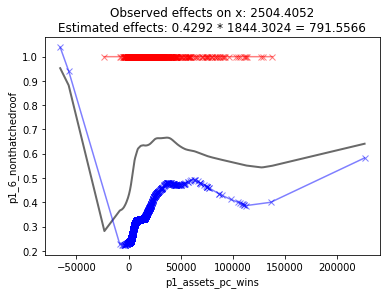

In [15]:
fig, ax = plot(
    df=df_svy,
    y='p1_6_nonthatchedroof',
    x='p1_assets_pc_wins')
plt.show()

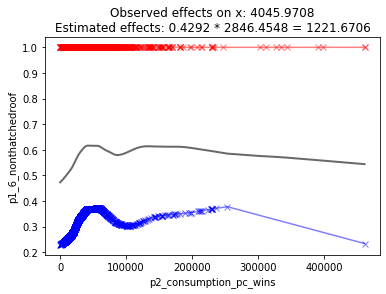

In [16]:
fig, ax = plot(
    df=df_svy,
    y='p1_6_nonthatchedroof',
    x='p2_consumption_pc_wins')
plt.show()

## Satellite

In [ ]:
df = gpd.read_file(SAT_IN_GEOM_DIR)
# score threshold
df = df.loc[df['score'] > 0.9, :].copy()
# extract centroid
df.loc[:, 'centroid_lon'] = df.geometry.centroid.x.values
df.loc[:, 'centroid_lat'] = df.geometry.centroid.y.values

In [ ]:
# roof color, view histogram and scatter
# df['R_mean'].plot(kind='hist', bins=50)
# pd.DataFrame(df).plot.scatter(x='R_mean', y='B_mean', alpha=0.1)
svm_coef = np.array([[-0.06021201, 0.0905571, 0.00755191]])
luma_coef = np.array([[0.3, 0.59, 0.11]])
svm_intercept = -6.17484352

df.loc[:, 'RGB_mean'] = np.mean(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_max'] = np.max(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_min'] = np.min(df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values, axis=1)
df.loc[:, 'RGB_svm'] = df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values.dot(svm_coef.T) + svm_intercept
df.loc[:, 'RGB_svm_metal'] = df.loc[:, 'RGB_svm'].values > 0
df.loc[:, 'RGB_maxminhalf'] = (df.loc[:, 'RGB_max'].values + df.loc[:, 'RGB_min'].values) / 2
df.loc[:, 'RGB_luma'] = df.loc[:, ['R_mean', 'G_mean', 'B_mean']].values.dot(luma_coef.T)

In [ ]:
# convert unit
df.loc[:, 'area'] *= ((0.001716 * 111000 / 800) ** 2)  # in sq meters

In [ ]:
df_sat = df.reset_index(drop=True)

In [ ]:
df_sat.loc[:, 'RGB_svm_metal'] = df_sat['RGB_svm_metal'].astype(np.float)

## Matching

In [ ]:
radius = 0.00045  # =50m
k = 10  # no. of nearest neighbors examined

In [ ]:
# match structures to households
# one structure is matched to one household at most
tree = scipy.spatial.cKDTree(
    df_svy.loc[:, ['s19_gps_longitude', 's19_gps_latitude']].values)
dists, svy_idxes = tree.query(
    df_sat.loc[:, ['centroid_lon', 'centroid_lat']].values, k=k)
rank, sat_idxes = np.meshgrid(range(k), range(df_sat.shape[0]))
assert (dists[:, -1] > radius).all(), 'increase k value'
svy_idxes = svy_idxes[dists < radius]
sat_idxes = sat_idxes[dists < radius]
df = pd.concat([
    df_svy.loc[svy_idxes, :].reset_index(drop=True),
    df_sat.loc[sat_idxes, :].reset_index(drop=True),
    pd.DataFrame({'rank': rank[dists < radius],
                  'distance': dists[dists < radius]}),
], axis=1)
df = df.sort_values(by=['s1_hhid_key', 'distance'])

In [ ]:
df_hh_closest = df.drop_duplicates(subset=['s1_hhid_key'], keep='first')

df_hh_closest = pd.merge(df_svy, df_hh_closest, how='left', on=df_svy.columns.tolist())

# df_hh_closest.loc[:, 'area'] = df_hh_closest['area'].fillna(0)
# df_hh_closest.loc[:, 'RGB_mean'] = df_hh_closest['RGB_mean'].fillna(
#     np.nanpercentile(df_hh_closest['RGB_mean'].values, 10)
# )

In [ ]:
df_hh = df.groupby(df_svy.columns.tolist()).agg(
    house_count=pd.NamedAgg(column='area', aggfunc='count'),
    area_sum=pd.NamedAgg(column='area', aggfunc='sum'),
    RGB_mean=pd.NamedAgg(column='RGB_mean', aggfunc='mean'),
    RGB_max=pd.NamedAgg(column='RGB_mean', aggfunc='max'),
).reset_index()
df_hh = pd.merge(df_svy, df_hh, how='left', on=df_svy.columns.tolist())

# df_hh.loc[:, 'house_count'] = df_hh['house_count'].fillna(0)
# df_hh.loc[:, 'area_sum'] = df_hh['area_sum'].fillna(0)

## Figures

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_svm_metal']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_svm_metal']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_svm_metal']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_svm_metal']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
# smf.ols('area ~ treat', data=df_hh_closest).fit().summary()

# smf.ols('RGB_mean ~ treat', data=df_hh_closest).fit().summary()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
# smf.ols('house_count ~ treat', data=df_hh).fit().summary()

In [ ]:
# fig, ax = plt.subplots()
# y = df_hh.loc[df_hh['treat'] == 1, 'area_sum']
# x = df_hh.loc[df_hh['treat'] == 1, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.5)
# # plt.plot(x, y, 'g+')
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_hh.loc[df_hh['treat'] == 0, 'area_sum']
# x = df_hh.loc[df_hh['treat'] == 0, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.5)
# # plt.plot(x, y, 'g+')
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# y = df_hh.loc[df_hh['treat'] == 1, 'area_sum']
# x = df_hh.loc[df_hh['treat'] == 1, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.5)
# # plt.plot(x, y, 'g+')
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_hh.loc[df_hh['treat'] == 0, 'area_sum']
# x = df_hh.loc[df_hh['treat'] == 0, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.5)
# # plt.plot(x, y, 'g+')
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

In [ ]:
# df_village = df_hh.groupby('village_code').agg(
#     treat=pd.NamedAgg(column='treat', aggfunc='mean'),
#     house_count=pd.NamedAgg(column='house_count', aggfunc='sum'),
#     area_sum=pd.NamedAgg(column='area_sum', aggfunc='sum'),
#     RGB_mean=pd.NamedAgg(column='RGB_mean', aggfunc='mean'),
#     p2_consumption_wins=pd.NamedAgg(column='p2_consumption_wins', aggfunc='mean'),
#     p1_assets_wins=pd.NamedAgg(column='p1_assets_wins', aggfunc='mean'),
# ).reset_index()

In [ ]:
# fig, ax = plt.subplots()
# y = df_village.loc[df_village['treat'] == 1, 'area_sum']
# x = df_village.loc[df_village['treat'] == 1, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_village.loc[df_village['treat'] == 0, 'area_sum']
# x = df_village.loc[df_village['treat'] == 0, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# y = df_village.loc[df_village['treat'] == 1, 'area_sum']
# x = df_village.loc[df_village['treat'] == 1, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_village.loc[df_village['treat'] == 0, 'area_sum']
# x = df_village.loc[df_village['treat'] == 0, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# y = df_village.loc[df_village['treat'] == 1, 'RGB_mean']
# x = df_village.loc[df_village['treat'] == 1, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_village.loc[df_village['treat'] == 0, 'RGB_mean']
# x = df_village.loc[df_village['treat'] == 0, 'p1_assets_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

In [ ]:
# fig, ax = plt.subplots()
# y = df_village.loc[df_village['treat'] == 1, 'RGB_mean']
# x = df_village.loc[df_village['treat'] == 1, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
# y = df_village.loc[df_village['treat'] == 0, 'RGB_mean']
# x = df_village.loc[df_village['treat'] == 0, 'p2_consumption_wins']
# lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'k+', alpha=0.2)
# plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
# plt.show()

## More specifications

* log + winsorize

In [ ]:
# take logs
# note to self: this also needs a bit more work
# I'm dropping <=0 values here
df_hh_closest.loc[:, 'log_p2_consumption_wins'] = winsorize(
    df_hh_closest['p2_consumption_wins'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)
df_hh_closest.loc[:, 'log_p1_assets_wins'] = winsorize(
    df_hh_closest['p1_assets_wins'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

### Matched to multiple structures

In [ ]:
# take logs
# note to self: this also needs a bit more work
# I'm dropping <=0 values here
df_hh.loc[:, 'log_p2_consumption_wins'] = winsorize(
    df_hh['p2_consumption_wins'], 5, 95
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)
df_hh.loc[:, 'log_p1_assets_wins'] = winsorize(
    df_hh['p1_assets_wins'], 5, 95
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)

In [ ]:
fig, ax = plt.subplots()
y = df_hh.loc[df_hh['treat'] == 1, 'area_sum']
x = df_hh.loc[df_hh['treat'] == 1, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh.loc[df_hh['treat'] == 0, 'area_sum']
x = df_hh.loc[df_hh['treat'] == 0, 'log_p1_assets_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh.loc[df_hh['treat'] == 1, 'area_sum']
x = df_hh.loc[df_hh['treat'] == 1, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh.loc[df_hh['treat'] == 0, 'area_sum']
x = df_hh.loc[df_hh['treat'] == 0, 'log_p2_consumption_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

* per capita

In [ ]:
df_hh_closest.loc[:, 'area_pc'] = df_hh_closest['area'].values / df_hh_closest['s4_q1_hhmembers'].values
df_hh_closest.loc[:, 'log_p2_consumption_pc_wins'] = winsorize(
    df_svy['p2_consumption_pc_wins'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)
df_hh_closest.loc[:, 'log_p1_assets_pc_wins'] = winsorize(
    df_svy['p1_assets_pc_wins'], 2.5, 97.5
).apply(
    lambda x: np.log(x) if x > 0 else np.nan
)

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'log_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'log_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

* sublocation fixed effects

In [ ]:
# demean by satcluster
df_hh_closest.loc[:, 'p2_consumption_pc_wins'] = winsorize(
    df_hh_closest['p2_consumption_pc_wins'], 5, 95)
df_hh_closest.loc[:, 'demean_p2_consumption_pc_wins'] = demean(
    df=df_hh_closest, column='p2_consumption_pc_wins', by=['satcluster'])
df_hh_closest.loc[:, 'p1_assets_pc_wins'] = winsorize(
    df_hh_closest['p1_assets_pc_wins'], 5, 95)
df_hh_closest.loc[:, 'demean_p1_assets_pc_wins'] = demean(
    df=df_hh_closest, column='p1_assets_pc_wins', by=['satcluster'])
df_hh_closest.loc[:, 'demean_RGB_mean'] = demean(
    df=df_hh_closest, column='RGB_mean', by=['satcluster'])
df_hh_closest.loc[:, 'demean_area_pc'] = demean(
    df=df_hh_closest, column='area_pc', by=['satcluster'])

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_RGB_mean']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.5)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_p1_assets_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plt.subplots()
y = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 1, 'demean_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'r+')
y = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_area_pc']
x = df_hh_closest.loc[df_hh_closest['treat'] == 0, 'demean_p2_consumption_pc_wins']
lowess = sm.nonparametric.lowess(y, x, frac=.3)
# plt.plot(x, y, 'g+')
plt.plot(lowess[:, 0], lowess[:, 1], 'b+')
plt.show()

In [ ]:
fig, ax = plot(
    df=df_hh_closest,
    y='area_pc',
    x='log_p2_consumption_pc_wins')
plt.show()

## GE Census

## Problem

I match GE census data (at baseline) to building polygons by finding the nearest neighbor to the geocode recorded in the census. The expectation is to compare roof materials and satellite based observables and validate the satellite based measurements. The output figure/table is the correlation between satellite based observables (eg color vector, building size) and census variables (roof materials, no. of rooms). This is not an Engel curve exercise, but merely validation.

## Diagnostics

Potential reasons for low correlation coefficients:

- Model is misspecified (possible, but not causing this)
- For luminosity, lack of satellite image fixed effects (nah)
- Imperfect geocoding, matched to neighbors or non-residential structures (nah)
- crappy ML prediction of building polygon (possible, but not causing this)
- Time mismatch between satellite and survey (possible)

I input the geocodes to google static maps, and randomly picked two village, and literally every building has an iron roof, no kidding. Maybe we just cannot see any thatched roof houses from google static map??? so they are being missed instead of scoring a low reflection score. However, I find that hard to believe, the geocodes clearly seem to be pointing to existing metal roof buildings.

I'm going to attribute the mismatch to time mismatch from now on, which we don't really know is what is going on, but I can't possibly find another explanation for this, looking at the images. Did rural Kenya really grow that much over the past five years? Maybe.

I'm going to abandon the census validation exercise, because roof material I think is the only thing that matters in the census, they don't have any consumption stuff, or anything detailed, and roof materials cannot be matched.

In [ ]:
# # build KD tree
# tree = scipy.spatial.cKDTree(df.loc[:, ['centroid_lon', 'centroid_lat']].values)

In [ ]:
# # read census master
# df = pd.read_stata(CENSUS_MASTER_IN_DIR)

# # df.columns.tolist()

# df = df.loc[:, [
#     'roof', 'roof_other', 'latitude', 'longitude', 'eligible',
#     'village_code', 'sat_grp', 'treat', 'hi_sat', 'roof_elig',
# ]]

In [ ]:
# # clean up roof category
# df.loc[:, 'roof'] = df['roof'].replace('', np.nan)
# df.loc[:, 'roof_other'] = df['roof_other'].replace('', np.nan).replace('.', np.nan)
# df.loc[df['roof_other'].notna(), 'roof'] = df.loc[df['roof_other'].notna(), 'roof_other']

# df.loc[:, 'roof'] = df['roof'].replace(
#     {'Unfinished (grass and polythene)': 'polythene',
#      'Polythene and grass': 'polythene',
#      'Reeds and grass': 'grass',
#      'Canvas Tent': 'canvas',
#      'Canvas tent': 'canvas',
#      'Polythine  bags': 'polythene',
#      'Partly grass,partly cement': 'cement',
#      'Canvas': 'canvas',
#      'leaves': 'grass'})

# df = df.loc[df['roof'].isin(['iron', 'grass']), :]

In [ ]:
# df = df.dropna(subset=['longitude', 'latitude'])
# df = df.reset_index(drop=True)

In [ ]:
# dists, idxes = tree.query(df.loc[:, ['longitude', 'latitude']].values, k=1)
# df = pd.concat([df, df_sat.loc[idxes, :].reset_index(drop=True)], axis=1)
# df.loc[:, 'dist'] = dists

In [ ]:
# is distance correlated with thatched roof?
# that would indicate that thatched roof buildings
# are not being recognized as buildings
# df = df.loc[df['dist'] < 0.001, :].reset_index(drop=True)
# smf.ols('eligible ~ I(dist > 0.0001)', data=df).fit().summary()
# some evidence that this is true
# but this shouldn't affect the correlation after
# distant matches are dropped

In [ ]:
# df = df.loc[df['dist'] < 0.0001, :].reset_index(drop=True)
# df['dist'].hist(bins=100)

In [ ]:
# df['R_mean'].hist(by=df['roof'], bins=50)
# df['G_mean'].hist(by=df['roof'], bins=50)
# df['B_mean'].hist(by=df['roof'], bins=50)

In [ ]:
# sample = np.random.random(df.shape[0]) > 0
# sample = df.loc[:, 'treat'].values == 0

In [ ]:
# smf.ols('eligible ~ RGB_mean', data=df).fit().summary()
# df.loc[:, ['eligible', 'RGB_mean']].corr()

In [ ]:
# smf.ols('eligible ~ RGB_mean + C(village_code)', data=df).fit().summary()
# the sign on RGB_mean is stable with or without village fixed effects

In [ ]:
# df.loc[:, 'roof_iron'] = (df['roof'] == 'iron').astype(int)

In [ ]:
# # ok, i need to just literally look at my data
# village_code = df['village_code'].unique().tolist()[35]
# fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
# df.loc[df['village_code'] == village_code, :].plot(
#     x='longitude', y='latitude', c='RGB_mean',
#     kind='scatter', cmap='coolwarm', ax=ax0)
# df.loc[df['village_code'] == village_code, :].plot(
#     x='longitude', y='latitude', c='roof_iron',
#     kind='scatter', cmap='coolwarm', ax=ax1)

In [ ]:
# df.loc[df['village_code'] == village_code, ['latitude', 'longitude', 'roof_iron', 'treat']]

In [ ]:
# X = df.loc[sample, ['R_mean', 'G_mean', 'B_mean']].values
# y = df.loc[sample, 'roof'].replace({'grass': 0, 'iron': 1}).values
# y.mean()
# clf = svm.SVC(kernel='linear')
# cross_val_score(clf, X, y, cv=5)